# Fine-Tuning Chronos-2 with LoRA for Stock Returns

This notebook uses:
- **LoRA (Low-Rank Adaptation)**: Only fine-tune a small subset of parameters to prevent overfitting
- **Multivariate forecasting**: All stocks inform each other via group attention
- **Optimized hyperparameters**: More data, lower LR, fewer steps

In [37]:
import sys
import os

current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
sys.path.append(project_root)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from tiingo_data.download_data import get_daily_returns_data_cached
from utils import get_device
from core.data import create_multivariate_windows, train_val_split, prepare_data_for_chronos
from core.eval import (
    run_chronos_sliding_backtest,
    summarize_backtest_results,
    evaluate_model_on_test,
    compare_models,
)
from chronos import Chronos2Pipeline
from peft import LoraConfig

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {get_device()}")

PyTorch version: 2.9.1
Device: mps


In [38]:
# Load and prepare data
df_all = get_daily_returns_data_cached()
df_train_clean, df_eval_clean = prepare_data_for_chronos(df_all, test_size=1200)

print(f"Training data shape: {df_train_clean.shape}")
print(f"Eval data shape: {df_eval_clean.shape}")

Training data shape: (2797, 114)
Eval data shape: (1200, 114)


In [39]:
# Hyperparameters - OPTIMIZED to prevent overfitting
context_length = 200
prediction_length = 1
stride = 10            # More windows (was 50)
learning_rate = 5e-6   # Increased from 1e-6 (validation loss still decreasing)
num_steps = 2000       # Increased from 1000 (no signs of overfitting)
batch_size = 32

# Create multivariate windows
all_inputs = create_multivariate_windows(
    df_train_clean,
    context_length=context_length,
    prediction_length=prediction_length,
    stride=stride,
)
print(f"Total training windows: {len(all_inputs)}")
print(f"Each window shape: {all_inputs[0]['target'].shape}")

# Train/validation split
train_inputs, val_inputs = train_val_split(all_inputs, val_ratio=0.1)
print(f"Train samples: {len(train_inputs)}, Val samples: {len(val_inputs)}")

Total training windows: 260
Each window shape: (114, 201)
Train samples: 234, Val samples: 26


In [40]:
# Load model
pipeline = Chronos2Pipeline.from_pretrained(
    "amazon/chronos-2",
    device_map=get_device(),
    dtype=torch.float32,
)
print(f"Model device: {pipeline.model.device}")

Model device: mps:0


In [41]:
# Evaluate zero-shot baseline
print("Evaluating zero-shot model...")
baseline_results = evaluate_model_on_test(
    pipeline=pipeline,
    df_test=df_eval_clean,
    context_length=context_length,
    n_samples=100,
)

print(f"\n=== ZERO-SHOT ===")
print(f"Quantile Loss: {baseline_results['mean_quantile_loss']:.6f}")
print(f"MSE: {baseline_results['mean_mse']:.6f}")
print(f"MAE: {baseline_results['mean_mae']:.6f}")

Evaluating zero-shot model...

=== ZERO-SHOT ===
Quantile Loss: 0.007240
MSE: 0.000557
MAE: 0.016263


In [42]:
# DIAGNOSTIC: Show all linear layer names in Chronos-2
print("="*80)
print("ALL LINEAR LAYERS IN CHRONOS-2 MODEL")
print("="*80)

linear_layer_names = []
for name, module in pipeline.model.named_modules():
    if isinstance(module, torch.nn.Linear):
        linear_layer_names.append(name)

print(f"\nFound {len(linear_layer_names)} linear layers\n")

# Show ALL layer names
for i, name in enumerate(linear_layer_names, 1):
    print(f"{i:3d}. {name}")

# Extract unique layer type suffixes
layer_suffixes = set()
for name in linear_layer_names:
    if '.' in name:
        suffix = name.split('.')[-1]
        layer_suffixes.add(suffix)

print("\n" + "="*80)
print(f"UNIQUE LAYER TYPES (suffixes): {sorted(layer_suffixes)}")
print("="*80)
print("\nUse these exact names in target_modules list for LoRA!")

ALL LINEAR LAYERS IN CHRONOS-2 MODEL

Found 126 linear layers

  1. input_patch_embedding.hidden_layer
  2. input_patch_embedding.output_layer
  3. input_patch_embedding.residual_layer
  4. encoder.block.0.layer.0.self_attention.q
  5. encoder.block.0.layer.0.self_attention.k
  6. encoder.block.0.layer.0.self_attention.v
  7. encoder.block.0.layer.0.self_attention.o
  8. encoder.block.0.layer.1.self_attention.q
  9. encoder.block.0.layer.1.self_attention.k
 10. encoder.block.0.layer.1.self_attention.v
 11. encoder.block.0.layer.1.self_attention.o
 12. encoder.block.0.layer.2.mlp.wi
 13. encoder.block.0.layer.2.mlp.wo
 14. encoder.block.1.layer.0.self_attention.q
 15. encoder.block.1.layer.0.self_attention.k
 16. encoder.block.1.layer.0.self_attention.v
 17. encoder.block.1.layer.0.self_attention.o
 18. encoder.block.1.layer.1.self_attention.q
 19. encoder.block.1.layer.1.self_attention.k
 20. encoder.block.1.layer.1.self_attention.v
 21. encoder.block.1.layer.1.self_attention.o
 22. en

In [43]:
# LoRA configuration - Targeting full attention mechanism
# Based on diagnostic output: Chronos-2 uses 'q', 'k', 'v', 'o' for attention

lora_config = LoraConfig(
    r=12,                           # Increased from 8 (no overfitting observed)
    lora_alpha=48,                  # Scaled proportionally (4:1 ratio)
    target_modules=["q", "k", "v", "o"],  # Full attention (was ["q", "v"])
    lora_dropout=0.1,
)

print("LoRA config (Full Attention):")
print(f"  r={lora_config.r}, alpha={lora_config.lora_alpha}, dropout={lora_config.lora_dropout}")
print(f"  target_modules={lora_config.target_modules}")
print(f"\nTargeting full attention mechanism (q,k,v,o) for maximum adaptation")
print(f"with increased rank (r=12) since no overfitting was observed.")

LoRA config (Full Attention):
  r=12, alpha=48, dropout=0.1
  target_modules={'v', 'o', 'q', 'k'}

Targeting full attention mechanism (q,k,v,o) for maximum adaptation
with increased rank (r=12) since no overfitting was observed.


In [44]:
# Fine-tune with LoRA
print(f"Fine-tuning with LoRA: {num_steps} steps, lr={learning_rate}")

finetuned = pipeline.fit(
    inputs=train_inputs,
    validation_inputs=val_inputs,
    prediction_length=prediction_length,
    context_length=context_length,
    min_past=context_length,
    num_steps=num_steps,
    batch_size=batch_size,
    learning_rate=learning_rate,
    finetune_mode="lora",
    lora_config=lora_config,
    output_dir="outputs/chronos2_lora",
)

Fine-tuning with LoRA: 2000 steps, lr=5e-06


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss
100,0.621000,0.503105
200,0.535900,0.491908
300,0.574800,0.485549
400,0.498900,0.482895
500,0.531400,0.480535
600,0.557800,0.480471
700,0.567500,0.481721
800,0.519600,0.483683
900,0.541200,0.481538
1000,0.514400,0.483557


In [45]:
# Evaluate fine-tuned model
print("Evaluating fine-tuned model...")
finetuned_results = evaluate_model_on_test(
    pipeline=finetuned,
    df_test=df_eval_clean,
    context_length=context_length,
    n_samples=100,
)

print(f"\n=== FINE-TUNED (LoRA) ===")
print(f"Quantile Loss: {finetuned_results['mean_quantile_loss']:.6f}")
print(f"MSE: {finetuned_results['mean_mse']:.6f}")
print(f"MAE: {finetuned_results['mean_mae']:.6f}")

# Compare
comparison = compare_models(baseline_results, finetuned_results)
print(f"\n=== IMPROVEMENT ===")
print(f"Quantile Loss: {comparison['quantile_loss_improvement']:+.2f}%")
print(f"MSE: {comparison['mse_improvement']:+.2f}%")
print(f"MAE: {comparison['mae_improvement']:+.2f}%")

Evaluating fine-tuned model...

=== FINE-TUNED (LoRA) ===
Quantile Loss: 0.007001
MSE: 0.000522
MAE: 0.015642

=== IMPROVEMENT ===
Quantile Loss: +3.30%
MSE: +6.23%
MAE: +3.82%


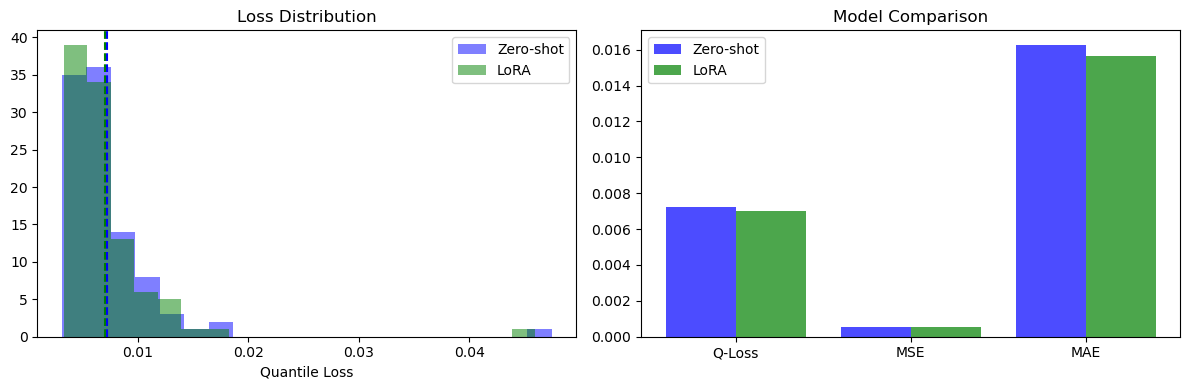

In [46]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss distribution
axes[0].hist(baseline_results['quantile_losses'], bins=20, alpha=0.5, label='Zero-shot', color='blue')
axes[0].hist(finetuned_results['quantile_losses'], bins=20, alpha=0.5, label='LoRA', color='green')
axes[0].axvline(baseline_results['mean_quantile_loss'], color='blue', linestyle='--')
axes[0].axvline(finetuned_results['mean_quantile_loss'], color='green', linestyle='--')
axes[0].set_xlabel('Quantile Loss')
axes[0].set_title('Loss Distribution')
axes[0].legend()

# Bar comparison
metrics = ['Q-Loss', 'MSE', 'MAE']
baseline_vals = [baseline_results['mean_quantile_loss'], baseline_results['mean_mse'], baseline_results['mean_mae']]
finetuned_vals = [finetuned_results['mean_quantile_loss'], finetuned_results['mean_mse'], finetuned_results['mean_mae']]
x = np.arange(len(metrics))
axes[1].bar(x - 0.2, baseline_vals, 0.4, label='Zero-shot', color='blue', alpha=0.7)
axes[1].bar(x + 0.2, finetuned_vals, 0.4, label='LoRA', color='green', alpha=0.7)
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].set_title('Model Comparison')
axes[1].legend()

plt.tight_layout()
plt.show()

In [47]:
# Full backtest
print("Running full backtest...")
results = run_chronos_sliding_backtest(
    pipeline=finetuned,
    df_returns=df_eval_clean,
    device=torch.device(get_device()),
    context_length=context_length,
)

print("\n=== BACKTEST ===")
print(summarize_backtest_results(results))

Running full backtest...


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


=== BACKTEST ===
{'mean_corr': np.float64(-0.01168907690827873), 'mean_r2': np.float64(-1.2318190039096009), 'mean_mse': np.float64(0.0005104198022631833), 'mean_mae': np.float64(0.01639149494413934)}


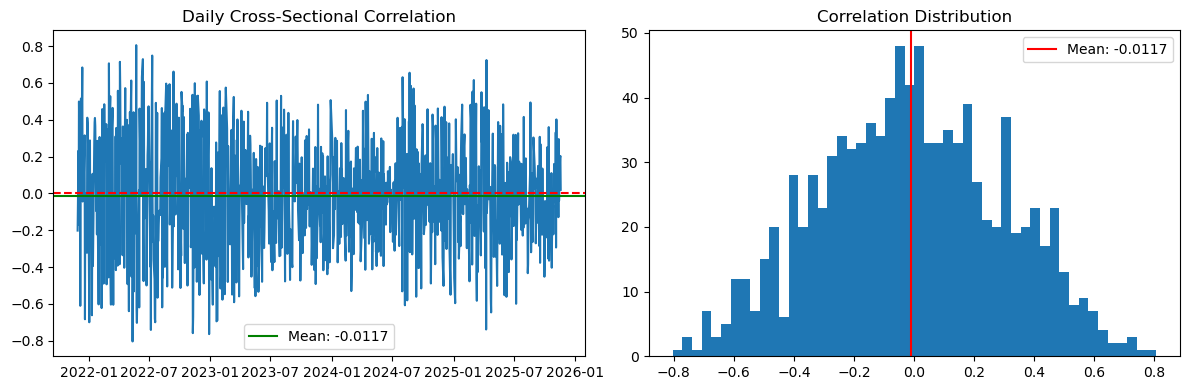

In [48]:
# Plot correlations
correlations = [m["corr"] for m in results["daily_metrics"]]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(results["dates"], correlations)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].axhline(y=np.mean(correlations), color='g', label=f'Mean: {np.mean(correlations):.4f}')
axes[0].set_title('Daily Cross-Sectional Correlation')
axes[0].legend()

axes[1].hist(correlations, bins=50)
axes[1].axvline(x=np.mean(correlations), color='r', label=f'Mean: {np.mean(correlations):.4f}')
axes[1].set_title('Correlation Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()